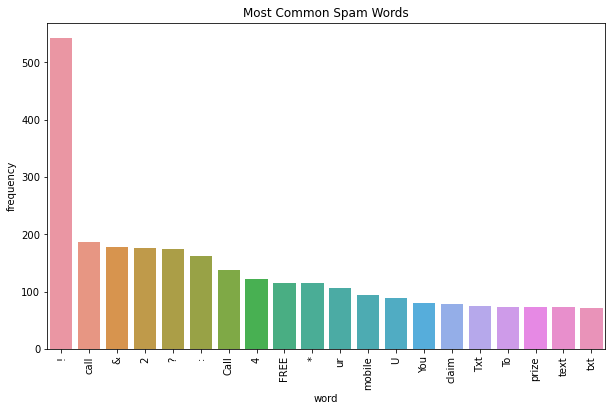

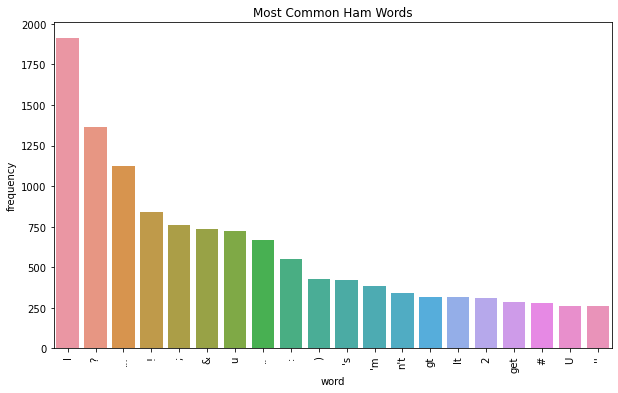




Training Set Size: 4457
(4457, 7748)
13.183856502242152% of Test Messages Were Spam
Success Rate: 98.83408071748879%
Accuracy for Ham Classification: 99.17355371900827
Accuracy for Spam Classification: 96.59863945578232


Message: Hello! Hope you are doing well today
  --> Ham!
Message: When are you heading over to my place 
  --> Ham!
Message: get it free now! win prizes and big savings! reply
  --> Spam!
Message: i mean i guess so thats what i was thinking
  --> Ham!


In [20]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from collections import Counter
import seaborn as sns


def eliminateStop(words, stop_words):
    
    returnList = [w for w in words if not w in stop_words]
    returnList = [w for w in returnList if not w in ['.', ',', '"', '\''] ]
    return returnList

def analyzeData(df):
    dfHam = df[df['Result'] == 0]
    dfSpam = df[df['Result']==1]
    
    hamWords = []
    for entry in dfHam['Filtered_Tokens']:
        for word in entry:
            hamWords.append(word)
            
    spamWords = []
    for entry in dfSpam['Filtered_Tokens']:
        for word in entry:
            spamWords.append(word)
    
    hamCount = Counter(hamWords)
    spamCount = Counter(spamWords)
    
    commonHam = pd.DataFrame(hamCount.most_common(20), columns=['word', 'frequency'])
    commonSpam = pd.DataFrame(spamCount.most_common(20), columns=['word', 'frequency'])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(x='word', y='frequency', data=commonSpam, ax=ax)
    plt.title("Most Common Spam Words")
    plt.xticks(rotation='vertical')
    plt.show()
    
    print('\n\n')
    fig2, ax2 = plt.subplots(figsize=(10,6))
    sns.barplot(x='word', y='frequency', data=commonHam, ax=ax2)
    plt.title("Most Common Ham Words")
    plt.xticks(rotation='vertical')
    plt.show()

    print('\n\n')

def main():
    pd.options.mode.chained_assignment = None
    # Read In Data and Format It Better
    df = pd.read_csv('spam.csv', sep=',', encoding='ISO-8859-1')
    df = df.drop(columns=[ "Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

    # Add 2 New Columns: For binary spam/ham indicator and length of message
    df['Result']= df['Classification'].map( {'spam' : int(1), 'ham' : int(0)})
    df['Message_Size'] = df['Text'].apply(len)
    
    # Tokenize And Remove StopWords 
    df['Tokens'] = df['Text'].apply(word_tokenize)
    stop_words = set(stopwords.words("english"))
    df['Filtered_Tokens'] = df['Tokens'].apply(eliminateStop, args=(stop_words,),)
    
    
    analyzeData(df)

   
    # Split Set Into Test Set and Training Set
    total = df['Result'].count()
    half = math.floor(total / 2)
    dfTrain, dfTest = train_test_split(df, test_size=0.2, shuffle=True)

    
   

   
    # # #   Naive Bayes # # #
    classifier = MultinomialNB()
    
    targs = dfTrain['Result'].values
    # Vectorize Message
    vectorizer = CountVectorizer()
    counts = vectorizer.fit_transform(dfTrain['Text'].values)
    
    trainSize = dfTrain['Result'].count()
    print(f'Training Set Size: {trainSize}')
    print(counts.shape)

    # Train data
    classifier.fit(counts, targs)
    # Test With Test Set
    predictions = classifier.predict(vectorizer.transform(dfTest['Text']))

    countRight = 0
    countWrong = [0, 0] # [ham, spam]
    i = 0
    for entry in dfTest['Result']:
        if (entry == predictions[i]):
            countRight+=1
        else:
            if (predictions[i] == 1):
                countWrong[1]+=1
            elif (predictions[i] == 0):
                countWrong[0]+=1
                
                
        i+=1
        
    
    size = dfTest['Result'].count()
   
    
    
    numSpams = dfTest[dfTest['Result']==1]['Result'].count()
    numHams = dfTest[dfTest['Result']==0]['Result'].count()
    
    spamAccuracy = 100 - (countWrong[1] / numSpams * 100)
    hamAccuracy = 100 - (countWrong[0] / numHams * 100)
    
    print(f'{numSpams / size * 100}% of Test Messages Were Spam')
    
    print(f'Success Rate: {countRight / size * 100}%')
    print(f'Accuracy for Ham Classification: {hamAccuracy}')
    print(f'Accuracy for Spam Classification: {spamAccuracy}\n\n')
    
    # Read User File For More!
    fileName = 'userMessages.txt'
    if fileName:
        with open(fileName) as f:
            messages = f.readlines()
            userData = vectorizer.transform(messages)
            predictions = classifier.predict(userData)
            
            i = 0
            for res in predictions:
                if res == 1:
                    answer = 'Spam!'
                elif res == 0:
                    answer = 'Ham!'
                print(f'Message: {messages[i]}  --> {answer}')
                i+=1
    
    
if __name__ =='__main__':
    main()